In [1]:
%load_ext autoreload
%autoreload 2

# Initial imports:
import os.path
from IPython.core.display import HTML

import numpy as np
import outer_spacem as osm
import pandas as pd
import scanpy as sc
import seaborn as sns
from IPython.core.display_functions import display
from matplotlib import pyplot as plt

from napari_spacem_qc import qc_utils as utils
from napari_spacem_qc.debug_utils import disable_interactive_plots
from napari_spacem_qc.parameters.report_parameters import \
    SpaceMQCParameters
from napari_spacem_qc.qc_utils import mprint, \
    get_general_config_parameters, compose_toc


In [2]:
# Tagged cell that will be usually rewritten by Papermill
# with the correct path to the config file:
config_file = "/Users/alberto-mac/Documents/DA_ESPORTARE/LOCAL_EMBL_FILES/g_shared/shared/alberto/projects/spacem-reports/australia-project/initial_reports/config_full.yml"
make_plots = True

In [3]:
utils.test_fct_()

test_fct2_


In [4]:
# ------------------------------------------------
# Load report config file and general parameters:
# ------------------------------------------------
if not make_plots:
    disable_interactive_plots()

report_config = SpaceMQCParameters(config_path=config_file)
# Check if all the config parameters are valid:
report_config.validate_all_tags()

params = get_general_config_parameters(
    report_config,
    requires_adata_pattern=True,
    print_report_header=True,
    mask_metadata=False,
    return_dictionary=True)

# Define some variables that will be needed later on:
slide_key = params["slide_key"]
bio_key = params["bio_key"]
repl_key = params["repl_key"]
palette = params["palette"]
process_slides_independently = params["process_slides_independently"]
row_key = params["row_key"]
col_key = params["col_key"]


# Single cell UOW
## Pixel/Cell QC Report
Project description: Initial datasets shared by Australian collaborators (Tassiani Sarretto, Helena Anastacio). Three conditions (stem cells, cells grown for 7 and 14 days). 12 replicates per condition.

Date: `2023-05-28`

Config: `/Users/alberto-mac/Documents/DA_ESPORTARE/LOCAL_EMBL_FILES/g_shared/shared/alberto/projects/spacem-reports/australia-project/initial_reports/config_full.yml`

Notebook version: `v0.2.0.post3+g966cb55.d20230408 (git-commit: 9f02807)`

## Report parameters
- Biological key: `growthConditions`
- Slide key: `slide`
- Process slides independently: `False`
- Replicate key: `replicate_nb_overall`
- Masking key: `mask_slide_TS36`
- AnnData pattern: `/Users/alberto-mac/Documents/DA_ESPORTARE/LOCAL_EMBL_FILES/g_shared/shared/alberto/projects/spacem-reports/australia-project/initial_reports/anndatas/{slide}-well{well}-{row}{col}.h5ad`
- AnnData type: `AnnDatas downloaded from Metaspace`
- Metadata file path: `/Users/alberto-mac/Documents/DA_ESPORTARE/LOCAL_EMBL_FILES/g_shared/shared/alberto/projects/spacem-reports/australia-project/initial_reports/metadata_mod_full.csv`


In [5]:
# ----------------
# Load AnnDatas
# ----------------

# If you need to do special filtering/normalizations/etc,
# you can skip them and manually perform a custom filtering afterwards

anndatas_per_slide = utils.load_anndatas_per_slide_batches(
    report_config,
    apply_filtering=True,
    normalize=True,
    apply_log1p=True
)

# The previous function returns a dictionary with the following structure:
# anndatas_per_slide = {
#     "slide_name_1": {
#             'adata': AnnData object,
#             'metadata': Pandas DataFrame with metadata of projects in slide,
#             'normalize': Whether scanpy.pp.normalize_total() was applied,
#             'pixel_qc', 'ion_qc': QC stats returned by
#                                   scanpy.pp.calculate_qc_metrics()
#             'apply_filtering': Whether sc.pp.filter_genes() and
#                                sc.pp.filter_cells() were applied,
#         },
#     "slide_name_2": {...}
#     ...
# }

# If all slides are loaded together (and not independently), the
# `anndatas_per_slide` dictionary contains only one element
# with name "All Slides".

In [6]:
# ----------------------
# Compute PCA and UMAP:
# ----------------------
# This may take some time, depending on the number of datasets:
anndatas_per_slide = utils.compute_pca_and_umap(anndatas_per_slide)

In [7]:
# -----------------------------
# Compute Leiden clustering:
# -----------------------------
# NOTE: This is still experimental: it may require some tweaking
# of the parameters
leiden_options = report_config.get("pixel_and_cell_qc/leiden_clustering", {})
perform_leiden_clustering = leiden_options.get("perform_leiden_clustering", False)

if perform_leiden_clustering:
    default_resolution = leiden_options.get(
        "default_resolution", 0.1)
    leiden_res_per_slide = leiden_options.get(
        "resolution_per_slide", {})

    for slide_name in anndatas_per_slide:
        adata_to_plot = anndatas_per_slide[slide_name]["adata"]
        metadata_to_plot = anndatas_per_slide[slide_name]["metadata"]

        # Perform Leiden clustering:
        cur_res = leiden_res_per_slide[slide_name] \
            if slide_name in leiden_res_per_slide else default_resolution
        sc.tl.leiden(adata_to_plot, resolution=cur_res,
                     random_state=12345)

        # Perform differential analysis:
        sc.tl.rank_genes_groups(adata_to_plot,
                                groupby="leiden", method="wilcoxon",
                                use_raw=True)

        anndatas_per_slide[slide_name]["adata"] = adata_to_plot

In [8]:
# ---------------------------
# Display Table of Content:
# ---------------------------
display(HTML(f'<h2 id="main_index">Table of Content</h2>'))

# TODO: improve ToC with table with references to subsections
toc_string = compose_toc(
    [
        ("Replicate coverage", "replicate_coverage"),
        ("List of datasets", "list_of_datasets")] +
    [
        (slide_name, utils.urlify(slide_name)) for slide_name
        in
        anndatas_per_slide],
)
mprint(toc_string)

1. [Replicate coverage](#replicate_coverage)
2. [List of datasets](#list_of_datasets)
3. [All Slides](#All-Slides)


[Go back to index](#main_index)

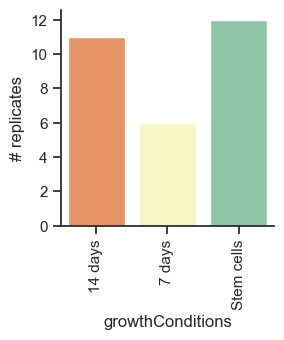

[Go back to index](#main_index)

,datasetName,datasetId,growthConditions,mask_slide_TS36,slide,row,col,replicate_nb_overall,group,submitter,PI,organism,organismPart,condition,mask_day_0,mask_day_7,mask_day_14,well,ionisationSource,maldiMatrix,analyzer,resPower400,polarity,uploadDateTime,FDR@10%,database,opticalImage,dataset_name,slide_batch_key,replicate_nb_per_slide_0,replicate_nb_overall_0,replicate_nb_per_slide_7,replicate_nb_overall_7,replicate_nb_per_slide,auto_generated_dataset_name
0,"TS37 well9 - Fixed neuronal cells, 30um, positive ion mode, sublimation DHA",2023-02-01_06h56m45s,14 days,False,TS37,C,2,1,nan,Tassiani Sarretto,Shane Ellis,cultured cells,Skin,control,True,True,False,9,MALDI,DHA,Orbitrap,120000,positive,2023-02-01T06:56:45.358,23,HMDB - v4,No optical image,TS37-well9-C2,1,nan,nan,nan,nan,1,TS37-C2
32,"TS34 well3_2 - Fixed neuronal cells, 30um, positive ion mode, sublimation DHA",2023-02-01_02h41m43s,Stem cells,False,TS34,C,1,10,nan,Tassiani Sarretto,Shane Ellis,cultured cells,Skin,control,False,True,True,3,MALDI,DHA,Orbitrap,120000,positive,2023-02-01T02:41:43.387,94,HMDB - v4,No optical image,TS34-well3-C1,2,4.000000,10.000000,nan,nan,4,TS34-C1
31,"TS34 well7 - Fixed neuronal cells, 30um, positive ion mode, sublimation DHA",2023-02-01_02h43m29s,Stem cells,False,TS34,A,2,9,nan,Tassiani Sarretto,Shane Ellis,cultured cells,Skin,control,False,True,True,7,MALDI,DHA,Orbitrap,120000,positive,2023-02-01T02:43:29.710,46,HMDB - v4,No optical image,TS34-well7-A2,2,3.000000,9.000000,nan,nan,3,TS34-A2
30,"TS34 well8 - Fixed neuronal cells, 30um, positive ion mode, sublimation DHA",2023-02-01_02h44m11s,Stem cells,False,TS34,B,2,8,nan,Tassiani Sarretto,Shane Ellis,cultured cells,Skin,control,False,True,True,8,MALDI,DHA,Orbitrap,120000,positive,2023-02-01T02:44:11.325,40,KEGG - v1,No optical image,TS34-well8-B2,2,2.000000,8.000000,nan,nan,2,TS34-B2
29,"TS34 well9 - Fixed neuronal cells, 30um, positive ion mode, sublimation DHA",2023-02-01_02h56m42s,Stem cells,False,TS34,C,2,7,nan,Tassiani Sarretto,Shane Ellis,cultured cells,Skin,control,False,True,True,9,MALDI,DHA,Orbitrap,120000,positive,2023-02-01T02:56:42.389,49,HMDB - v4,No optical image,TS34-well9-C2,2,1.000000,7.000000,nan,nan,1,TS34-C2
28,TS33 well1,2023-02-01_02h06m42s,Stem cells,False,TS33,A,1,6,nan,Tassiani Sarretto,Shane Ellis,cultured cells,neuron,control,False,True,True,1,MALDI,DHA,Orbitrap,120000,positive,2023-02-01T02:06:42.827,193,HMDB - v4,No optical image,TS33-well1-A1,1,6.000000,6.000000,nan,nan,6,TS33-A1
27,TS33 well2,2023-02-01_02h11m55s,Stem cells,False,TS33,B,1,5,nan,Tassiani Sarretto,Shane Ellis,cultured cells,neuron,control,False,True,True,2,MALDI,DHA,Orbitrap,120000,positive,2023-02-01T02:11:55.197,55,HMDB - v4,No optical image,TS33-well2-B1,1,5.000000,5.000000,nan,nan,5,TS33-B1
26,"TS33 well3 -Fixed neuronal cells, 30um, positive ion mode, sublimation DHA",2023-02-01_02h13m08s,Stem cells,False,TS33,C,1,4,nan,Tassiani Sarretto,Shane Ellis,cultured cells,neuron,control,False,True,True,3,MALDI,DHA,Orbitrap,120000,positive,2023-02-01T02:13:08.967,32,HMDB - v4,No optical image,TS33-well3-C1,1,4.000000,4.000000,nan,nan,4,TS33-C1
25,"TS33 well7 - Fixed neuronal cells, 30um, positive ion mode, sublimation DHA",2023-02-01_02h14m02s,Stem cells,False,TS33,A,2,3,nan,Tassiani Sarretto,Shane Ellis,cultured cells,neuron,control,False,True,True,7,MALDI,DHA,Orbitrap,120000,positive,2023-02-01T02:14:02.055,147,HMDB - v4,No optical image,TS33-well7-A2,1,3.000000,3.000000,nan,nan,3,TS33-A2
24,"TS33 well9 - Fixed neuronal cells, 30um, positive ion mode, sublimation DHA",2023-02-01_02h15m58s,Stem cells,False,TS33,C,2,2,nan,Tassiani Sarretto,Shane Ellis,cultured cells,Skin,control,False,True,True,9,MALDI,DHA,Orbitrap,120000,positive,2023-02-01T02:15:58.683,122,HMDB - v4,No optical image,TS33-well9-C2,1,2.000000,2.000000,nan,nan,2,TS33-C2


In [9]:
# --------------------------------------------
# Plot replicate coverage and metadata table:
# --------------------------------------------
utils.plot_replicate_coverage(report_config=report_config)
utils.print_metadata_table(report_config=report_config)

In [10]:
# -----------------------------
# Define plotting functions:
# -----------------------------
# Note: The actual plots are done in the last cell of the notebook


def pca_lineplot(adata_to_plot):
    n_comps = adata_to_plot.obsm["X_pca"].shape[1]

    plt.figure(figsize=(5, 5))
    sns.lineplot(
        x=np.arange(n_comps),
        y=adata_to_plot.uns["pca"]["variance_ratio"].cumsum(),
        palette="Deep",
    )

    plt.locator_params(nbins=5)
    # plt.grid(visible=True, linestyle=":")
    plt.ylim(-0.05, 1.05)
    plt.xlabel("Components")
    plt.ylabel("Cumulative variance covered")
    sns.despine()
    plt.show()

In [11]:
def pca_scatter_plot(adata_to_plot, metadata_to_plot):
    col_order = np.sort(np.unique(metadata_to_plot[bio_key]))
    f = osm.pl.highlight_scatterplot(
        data=adata_to_plot,
        obsm_key="X_pca",
        hue=repl_key,
        col=bio_key,
        col_wrap=min(len(metadata_to_plot[bio_key].unique()), 4),
        height=4,
        aspect=0.9,
        scatter_kwargs=dict(s=5),
        trim_axes=True,
        decorate_titles=True,
        titles_palette=palette.to_dict(),
        col_order=col_order,
        palette="husl",
    )
    f.add_legend(markerscale=5)
    plt.show()

In [12]:
def umap_scatter_plot(adata_to_plot, metadata_to_plot):
    col_order = np.sort(np.unique(metadata_to_plot[bio_key]))
    f = osm.pl.highlight_scatterplot(
        data=adata_to_plot,
        obsm_key="X_umap",
        hue=repl_key,
        col=bio_key,
        col_wrap=min(len(metadata_to_plot[bio_key].unique()), 4),
        height=4,
        aspect=0.9,
        scatter_kwargs=dict(s=5, alpha=0.6),
        trim_axes=True,
        decorate_titles=True,
        titles_palette=palette.to_dict(),
        col_order=col_order,
        palette="husl",
    )

    f.add_legend(markerscale=5)
    plt.show()

In [13]:
def umap_scatter_plot_with_well_positions(adata_to_plot, metadata_to_plot):
    mprint(
        "Potential variance in UMAP associated with x/y position of well on slide"
    )

    # Make index unique, otherwise next line may fail:
    adata_to_plot.obs_names_make_unique()
    adata_to_plot.obs[row_key] = (
        adata_to_plot.obs[row_key].sort_values().astype("category").cat.codes
    )
    adata_to_plot.obs[["UMAP1", "UMAP2"]] = adata_to_plot.obsm["X_umap"]
    plot_data = adata_to_plot.obs.melt(
        id_vars=["UMAP1", "UMAP2"], value_vars=[row_key, col_key]
    )

    g = sns.FacetGrid(
        data=plot_data,
        col="variable",
        height=4,
        aspect=0.9,
        col_order=[row_key, col_key]
    )

    for (row_i, col_j, cue), data_ijk in g.facet_data():
        ax = g.facet_axis(row_i, col_j)

        # Use different palettes for each column
        if col_j == 0:
            col_palette = 'mercury'
        elif col_j == 1:
            col_palette = 'husl'
        else:
            raise ValueError(f"Invalid col_j value: {col_j}")
        sns.scatterplot(
            data=data_ijk,
            x="UMAP1",
            y="UMAP2",
            hue="value",
            linewidth=0,
            s=5,
            palette=col_palette,
            ax=ax,
            alpha=0.5
        )
        # Add separate legends for each plot in the grid:
        ax.legend(loc='best')

    # Remove x and y ticks
    g.set(xticks=[], yticks=[])
    # Add titles to the columns
    g.set_titles("{col_name}")

    plt.show()

In [14]:
def umap_scatter_plot_with_slide_number(adata_to_plot, metadata_to_plot):
    # Plot UMAP with slide number, if not plotting slides independently:
    if not process_slides_independently:
        mprint(
            "Potential variance in UMAP associated with slide number (independent on condition)"
        )
        f = osm.pl.highlight_scatterplot(
            data=adata_to_plot,
            obsm_key="X_umap",
            hue=repl_key,
            col=slide_key,
            col_wrap=min(len(metadata_to_plot[slide_key].unique()), 4),
            height=4,
            aspect=0.9,
            scatter_kwargs=dict(s=5, alpha=0.6),
            trim_axes=True,
            palette="husl",
        )

        f.add_legend(markerscale=5)
        plt.show()

In [15]:
def plot_replicate_distances(adata_to_plot):
    g = utils.dist_ratios(
        adata_to_plot, bio_label=bio_key, repl_label=repl_key, palette=palette
    )
    plt.show()
    if g is not None:
        mprint(
        """
Circle size and number inside circles correspond to euclidean distance $D_{BIO}$ between the average PCA representation of biological label `query` and `reference`.
Circle size and number inside circles *on the bottom row* correspond to average pairwise distance $D_{REP}$ between replicates for individual biological labels, weighted by replicates' population sizes.
Circle fill color corresponds to the log2 ratio $R$ of $D_{BIO}$ to $D_{REP}$, according to $R=Log_{2}(D_{BIO}/D_{REP})$.
Note that while distances are symmetrical for `query`-`reference` pairs, $R$ is not due to division by $D_{REP}$.

A negative $R$ (i.e. a red circle) should raise your attention, as this will mean that the specific query group is closer to the query than the query's replicates are spaced from each other on average,
indicating that technical variance is stronger than biological variance for these groups.
Keep in mind to include your biological context into interpretation of this plot, as certain overlaps between conditions may be expected depending on biological labels.
    """
        )

In [16]:
# ---------------------------------------------
# Define plot functions for Leiden Clustering:
# ---------------------------------------------

def plot_leiden_umaps(adata_to_plot):
    mprint("#### Leiden clustering")

    # Create a consistent color palette
    keys = adata_to_plot.obs["leiden"].unique()
    colors = sns.color_palette("tab10", n_colors=len(keys))

    leiden_palette = dict(zip(keys, colors))

    adata_to_plot.uns["leiden_colors"] = sns.color_palette(
        "tab10",
        n_colors=len(adata_to_plot.obs["leiden"].unique())
    )

    f = osm.pl.highlight_scatterplot(
        data=adata_to_plot,
        obsm_key="X_umap",
        hue="leiden",
        col="leiden",
        decorate_titles=True,  # Decorate titles
        height=5,
        scatter_kwargs=dict(s=5),
        trim_axes=True  # ...And draw some more minimalist axes
    )

    f.add_legend(markerscale=3)

    plt.xticks([])
    plt.yticks([])
    plt.show()

In [17]:
def umap_plots_significant_ions(adata_to_plot):
    top_n = 10

    groupname = adata_to_plot.uns["rank_genes_groups"]["params"][
        "groupby"]  # = "leiden"

    # Plot UMAP significant ions:
    for group in adata_to_plot.obs[groupname].unique().categories:
        df = sc.get.rank_genes_groups_df(adata_to_plot, group)
        df["abs_scores"] = np.abs(df["scores"])
        df = df.sort_values("abs_scores", ascending=False)

        # f = osm.pl.highlight_scatterplot(
        #     data=adata,
        #     obsm_key="X_umap",
        #     hue="leiden",
        #     col="leiden",
        #     decorate_titles=True,  # Decorate titles
        #     height=1,
        #     scatter_kwargs=dict(s=5),
        #     trim_axes=True  # ...And draw some more minimalist axes
        # )
        #
        # f.add_legend(markerscale=3)
        #
        # plt.xticks([])
        # plt.yticks([])
        # plt.show()

        ions = df.iloc[:top_n].names.tolist()

        f = sc.pl.umap(
            adata_to_plot,
            color=ions,
            cmap="mercury_r",
            # gene_symbols=,
            s=50,
            layer="clipped",
            show=False
        )

        fig = f[0].figure
        fig.suptitle(f"{str(groupname).capitalize()}: {group}", x=0.05, y=1,
                     ha="left", size=15)
        plt.show()



In [18]:
def make_DE_volcano_plots(
        adata_to_plot,
        slide_name,
        save_csv_significant_molecules=True,
        max_labels_per_volcano_plot=20,
        pval_thres=0.05,  # upper threshold for p-values
        fc_thres=2,  # lower threshold for fold changes

):
    groupname = adata_to_plot.uns["rank_genes_groups"]["params"][
        "groupby"]  # = "leiden"

    for group in adata_to_plot.obs[groupname].unique().categories:
        df = sc.get.rank_genes_groups_df(adata_to_plot, group)
        df = df.sort_values("scores", ascending=False)

        df.insert(0, groupname, group)

        df["significance"] = (df["pvals_adj"] < pval_thres) & (
                df["logfoldchanges"].abs() > np.log2(fc_thres))
        df["pvals_adj_nlog10"] = -np.log10(df["pvals_adj"] + 1e-300)

        # Add inchi column and molecule names:
        df.rename(columns={"names": "ion"}, inplace=True)
        df = pd.merge(df, adata_to_plot.var[
            ['annotation_id', 'moleculeNames', 'moleculeIds']],
                      left_on="ion",
                      right_on="annotation_id",
                      how='left')
        df.drop(columns="annotation_id", inplace=True)

        df = df.drop(columns="leiden")

        plt.figure(figsize=[20, 15])
        sns.scatterplot(
            data=df,
            x="logfoldchanges",
            y="pvals_adj_nlog10",
            s=15,
            linewidth=0,
            hue="significance",
            palette="tab10"
        )
        plt.xlabel("Log fold change")
        plt.ylabel("-log10(p)")
        plt.legend(loc="lower left", title="Significance")
        plt.title(f"{groupname}={group}", fontsize=20)

        # Add marker labels:
        line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        line_colors *= 100
        # for (row_i, col_j, cue), data_ijk in g.facet_data():
        #     ax = g.facet_axis(row_i, col_j)
        # batch_name = data_ijk[BATCH_KEY_COL].unique()[0]
        # covered_markers = covered_markers_collected[batch_name]
        markers_to_label = df[df["significance"]]
        markers_to_label["abs_scores"] = np.abs(
            markers_to_label["scores"])
        markers_to_label = markers_to_label.sort_values("abs_scores",
                                                        ascending=False)

        # Get plot limits and place labels randomly:
        xlims = plt.xlim()
        ylims = plt.ylim()
        x_range = xlims[1] - xlims[0]
        y_range = ylims[1] - ylims[0]



        for i, (_, row) in enumerate(markers_to_label.iterrows()):
            new_x = utils.randomly_shift_pos(row["logfoldchanges"], xlims)
            new_y = utils.randomly_shift_pos(row["pvals_adj_nlog10"], ylims)
            plt.plot((row["logfoldchanges"], new_x),
                     (row["pvals_adj_nlog10"], new_y), alpha=0.6,
                     color=line_colors[i])

            # Get shorter version of first name:
            short_firt_name = eval(row['moleculeNames'])[0]
            if len(short_firt_name) > 20:
                short_firt_name = short_firt_name[:20] + "..."
            plt.text(new_x, new_y,
                     s=f"{row['ion']} ({short_firt_name})",
                     alpha=0.9, size=10)
            if i > max_labels_per_volcano_plot:
                break

        plt.show()

        # Save list of metabolites:
        if save_csv_significant_molecules:
            output_dir = os.path.split(config_file)[0]

            # df = sc.get.rank_genes_groups_df(adata, group)
            df = df.sort_values("scores", ascending=False)

            # Display table in report:
            df_to_show = df.copy()
            df_to_show["abs_scores"] = np.abs(
                df_to_show["scores"])
            df_to_show = df_to_show.sort_values("abs_scores",
                                                ascending=False)
            df_to_show = df_to_show.iloc[:30]
            display(df_to_show.style)

            df.insert(0, groupname, group)

            df = df[
                (df["pvals"] < pval_thres) &
                (df["logfoldchanges"].abs() > np.log2(fc_thres))
                ]

            df_path = f"{output_dir}/{slide_key}_{slide_name}_{groupname}_{group}_markers.csv"
            #                 print(df_path)
            df.to_csv(df_path, index=False)

In [19]:
# # -----------------------------
# # Make the actual plots:
# # -----------------------------
# # (comment out the plots you don't want to include in the report)
# # Note: Leiden clustering plots are still experimental, and they may require
# # some tweaking of the parameters
#
# for slide_name in anndatas_per_slide:
#     adata_to_plot = anndatas_per_slide[slide_name]["adata"]
#     metadata_to_plot = anndatas_per_slide[slide_name]["metadata"]
#     slide_name_urlified = utils.urlify(slide_name)
#
#     # Add headers with anchors (so they can be reached by the Table of Content)
#     display(HTML(f'<h2 id="{slide_name_urlified}">{slide_name}</h2>'))
#
#     # Plot well layout:
#     mprint(f"[Go back to index](#main_index)")
#     utils.plot_well_layouts(
#         report_config=report_config,
#         slide_name_to_plot=slide_name)
#
#     # Plot AnnDatas stats:
#     utils.plot_anndatas_stats(
#         anndatas_per_slide,
#         slide_name_to_plot=slide_name)
#
#     mprint(f"### PCA ({slide_name})")
#     pca_lineplot(adata_to_plot)
#     pca_scatter_plot(adata_to_plot, metadata_to_plot)
#
#     mprint(f"### UMAP ({slide_name})")
#     umap_scatter_plot(adata_to_plot, metadata_to_plot)
#     umap_scatter_plot_with_well_positions(adata_to_plot, metadata_to_plot)
#     umap_scatter_plot_with_slide_number(adata_to_plot, metadata_to_plot)
#
#     mprint(f"### Distance between datasets ({slide_name})")
#     g = utils.clustermap(
#         adata_to_plot, groupby=[bio_key, repl_key], palette=palette
#     )
#     plt.show()
#
#     mprint(f"### Intra-label vs. inter-label distance ({slide_name})")
#     plot_replicate_distances(adata_to_plot)

In [20]:
import pickle
# Pickle anndatas_per_slide_bkk to disk for later use:
output_dir = os.path.split(config_file)[0]
# with open(f"{output_dir}/anndatas_per_slide_bkk.pickle", 'wb') as f:
#     pickle.dump(anndatas_per_slide_bkk, f, pickle.HIGHEST_PROTOCOL)
# # Do the same for anndatas_per_slide_combat and anndatas_per_slide:
# with open(f"{output_dir}/anndatas_per_slide_combat.pickle", 'wb') as f:
#     pickle.dump(anndatas_per_slide_combat, f, pickle.HIGHEST_PROTOCOL)
with open(f"{output_dir}/anndatas_per_slide.pickle", 'wb') as f:
    pickle.dump(anndatas_per_slide, f, pickle.HIGHEST_PROTOCOL)

TypeError: eval() arg 1 must be a string, bytes or code object

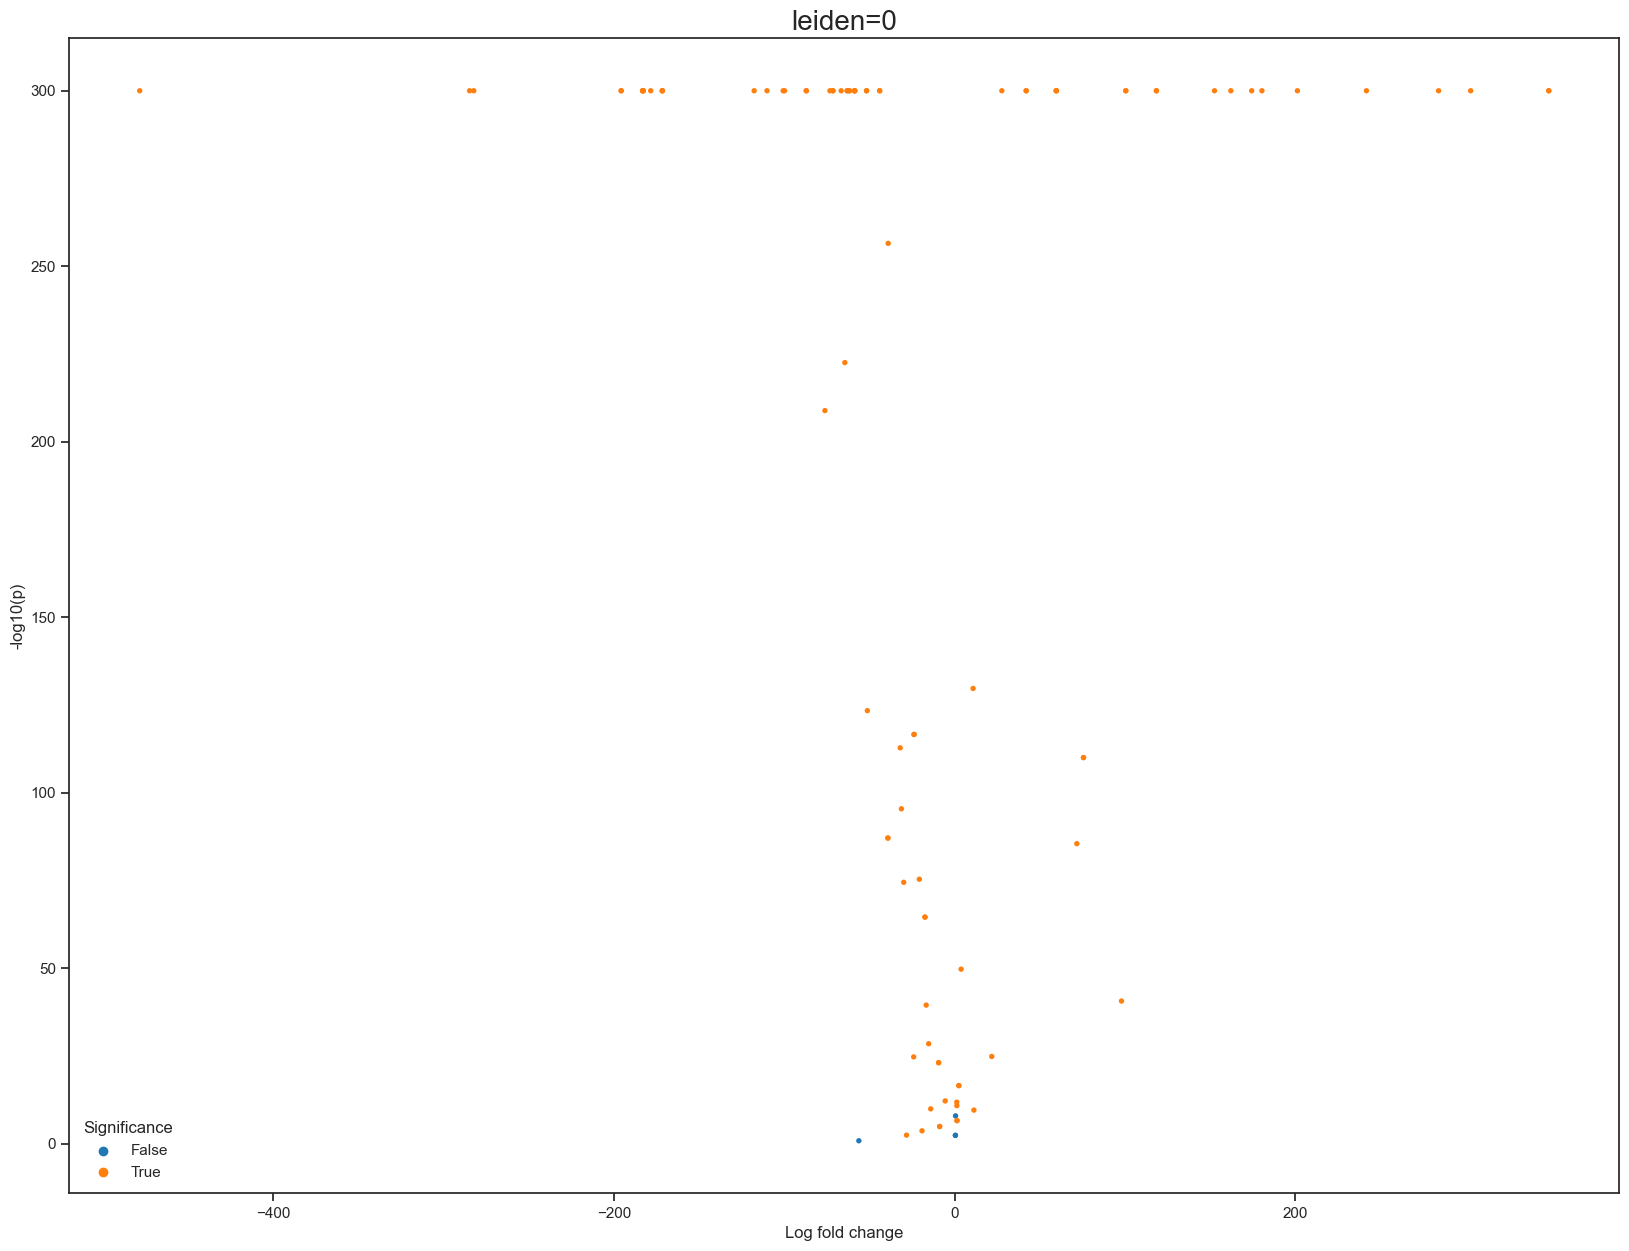

In [21]:


for slide_name in anndatas_per_slide:
    adata_to_plot = anndatas_per_slide[slide_name]["adata"]
    if perform_leiden_clustering:
        # Prepare the data:
        lower, upper = np.quantile(adata_to_plot.raw.X, [0.01, 0.99],
                                   axis=0)
        adata_to_plot.layers["clipped"] = np.clip(adata_to_plot.raw.X, lower,
                                                  upper)

        groupname = adata_to_plot.uns["rank_genes_groups"]["params"][
            "groupby"]  # = "leiden"

        # mprint(f"### Leiden clustering ({slide_name})")
        # plot_leiden_umaps(adata_to_plot)
        #
        # mprint(f"### DE analysis plots ({slide_name})")
        # # Plot molecules:
        # sc.pl.rank_genes_groups(adata_to_plot, sharey=False, fontsize=12,
        #                         gene_symbols="formula")
        #
        # umap_plots_significant_ions(adata_to_plot)

        save_csv_significant_molecules=leiden_options.get(
                "save_csv_significant_molecules", True),
        max_labels_per_volcano_plot=leiden_options.get(
            "max_labels_per_volcano_plot", 20),
        pval_thres=leiden_options.get(
            "pval_thres", 0.05),
        fc_thres=leiden_options.get(
                "fc_thres", 2)


        for group in adata_to_plot.obs[groupname].unique().categories:
            df = sc.get.rank_genes_groups_df(adata_to_plot, group)
            df = df.sort_values("scores", ascending=False)

            df.insert(0, groupname, group)

            df["significance"] = (df["pvals_adj"] < pval_thres) & (
                    df["logfoldchanges"].abs() > np.log2(fc_thres))
            df["pvals_adj_nlog10"] = -np.log10(df["pvals_adj"] + 1e-300)

            # Add inchi column and molecule names:
            df.rename(columns={"names": "ion"}, inplace=True)
            df = pd.merge(df, adata_to_plot.var[
                ['annotation_id', 'moleculeNames', 'moleculeIds']],
                          left_on="ion",
                          right_on="annotation_id",
                          how='left')
            df.drop(columns="annotation_id", inplace=True)

            df = df.drop(columns="leiden")

            plt.figure(figsize=[20, 15])
            sns.scatterplot(
                data=df,
                x="logfoldchanges",
                y="pvals_adj_nlog10",
                s=15,
                linewidth=0,
                hue="significance",
                palette="tab10"
            )
            plt.xlabel("Log fold change")
            plt.ylabel("-log10(p)")
            plt.legend(loc="lower left", title="Significance")
            plt.title(f"{groupname}={group}", fontsize=20)

            # Add marker labels:
            line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
            line_colors *= 100
            # for (row_i, col_j, cue), data_ijk in g.facet_data():
            #     ax = g.facet_axis(row_i, col_j)
            # batch_name = data_ijk[BATCH_KEY_COL].unique()[0]
            # covered_markers = covered_markers_collected[batch_name]
            markers_to_label = df[df["significance"]]
            markers_to_label["abs_scores"] = np.abs(
                markers_to_label["scores"])
            markers_to_label = markers_to_label.sort_values("abs_scores",
                                                            ascending=False)

            # Get plot limits and place labels randomly:
            xlims = plt.xlim()
            ylims = plt.ylim()
            x_range = xlims[1] - xlims[0]
            y_range = ylims[1] - ylims[0]

            # Get shorter version of first name:
            short_firt_name = eval(df['moleculeNames'])[0]
            if len(short_firt_name) > 20:
                short_firt_name = short_firt_name[:20] + "..."
        #     ==============================
        #     ==============================




        mprint(f"### Volcano plots ({slide_name})")
        make_DE_volcano_plots(
            adata_to_plot,
            slide_name,
            save_csv_significant_molecules=leiden_options.get(
                "save_csv_significant_molecules", True),
            max_labels_per_volcano_plot=leiden_options.get(
                "max_labels_per_volcano_plot", 20),
            pval_thres=leiden_options.get(
                "pval_thres", 0.05),
            fc_thres=leiden_options.get(
                "fc_thres", 2)
        )
        break


In [ ]:
# Get shorter version of first name:
short_firt_name = eval(df['moleculeNames'])[0]
if len(short_firt_name) > 20:
    short_firt_name = short_firt_name[:20] + "..."


In [ ]:
df
